In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Messis Model Architecture Experimentation

The purpose of this notebook is to evaluate a possible architecture for our crop classification model based on Prithvi.

## Loading TemporalViTEncoder from Prithvi

In [3]:
from prithvi.geospatial_fm import TemporalViTEncoder

bands = [0, 1, 2, 3, 4, 5]

loss_weights_multi = [
    0.386375,
    0.661126,
    0.548184,
    0.640482,
    0.876862,
    0.925186,
    3.249462,
    1.542289,
    2.175141,
    2.272419,
    3.062762,
    3.626097,
    1.198702,
]
loss_func = dict(
    type="CrossEntropyLoss",
    use_sigmoid=False,
    class_weight=loss_weights_multi,
    avg_non_ignore=True,
)

prithvi = TemporalViTEncoder(
    img_size=224,
    patch_size=16,
    num_frames=3,
    tubelet_size=1,
    in_chans=len(bands),
    embed_dim=768,
    depth=12, # weirdly 12 in the Pritvi_100M.pth but was set to 6 in the original code, and 24 default value
    num_heads=8,
    mlp_ratio=4.0,
    norm_pix_loss=False,
    pretrained='../prithvi/models/Prithvi_100M.pt'
)

load from ./prithvi/models/Prithvi_100M.pt
load checkpoint from local path: ./prithvi/models/Prithvi_100M.pt
The model and loaded state dict do not match exactly

unexpected key in source state_dict: mask_token, decoder_pos_embed, decoder_embed.weight, decoder_embed.bias, decoder_blocks.0.norm1.weight, decoder_blocks.0.norm1.bias, decoder_blocks.0.attn.qkv.weight, decoder_blocks.0.attn.qkv.bias, decoder_blocks.0.attn.proj.weight, decoder_blocks.0.attn.proj.bias, decoder_blocks.0.norm2.weight, decoder_blocks.0.norm2.bias, decoder_blocks.0.mlp.fc1.weight, decoder_blocks.0.mlp.fc1.bias, decoder_blocks.0.mlp.fc2.weight, decoder_blocks.0.mlp.fc2.bias, decoder_blocks.1.norm1.weight, decoder_blocks.1.norm1.bias, decoder_blocks.1.attn.qkv.weight, decoder_blocks.1.attn.qkv.bias, decoder_blocks.1.attn.proj.weight, decoder_blocks.1.attn.proj.bias, decoder_blocks.1.norm2.weight, decoder_blocks.1.norm2.bias, decoder_blocks.1.mlp.fc1.weight, decoder_blocks.1.mlp.fc1.bias, decoder_blocks.1.mlp.fc2.we

These params are set up like the Pritvhi team did it for it's "multi temporal crop classification" fine-tune. We get `unexpected key in source state_dict:`, as the model state is actually `MaskedAutoencoderViT` (https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M/blob/main/Prithvi.py), which also included the decoder. The decoder is not needed for the classification task, so we can just load the encoder part of the model and ignore the warning. Our encoder's architecture is defined as `TemporalViTEncoder` (https://github.com/NASA-IMPACT/hls-foundation-os/blob/main/geospatial_fm/geospatial_fm.py).

The prithvi fine-tune uses FCNHead as classification head. We want to build upon this, making hierarchical classification possible.

```python
# Copyright (c) OpenMMLab. All rights reserved.
import torch
import torch.nn as nn
from mmcv.cnn import ConvModule

from mmseg.registry import MODELS
from .decode_head import BaseDecodeHead


@MODELS.register_module()
class FCNHead(BaseDecodeHead):
    """Fully Convolution Networks for Semantic Segmentation.

    This head is implemented of `FCNNet <https://arxiv.org/abs/1411.4038>`_.

    Args:
        num_convs (int): Number of convs in the head. Default: 2.
        kernel_size (int): The kernel size for convs in the head. Default: 3.
        concat_input (bool): Whether concat the input and output of convs
            before classification layer.
        dilation (int): The dilation rate for convs in the head. Default: 1.
    """

    def __init__(self,
                 num_convs=2,
                 kernel_size=3,
                 concat_input=True,
                 dilation=1,
                 **kwargs):
        assert num_convs >= 0 and dilation > 0 and isinstance(dilation, int)
        self.num_convs = num_convs
        self.concat_input = concat_input
        self.kernel_size = kernel_size
        super().__init__(**kwargs)
        if num_convs == 0:
            assert self.in_channels == self.channels

        conv_padding = (kernel_size // 2) * dilation
        convs = []
        convs.append(
            ConvModule(
                self.in_channels,
                self.channels,
                kernel_size=kernel_size,
                padding=conv_padding,
                dilation=dilation,
                conv_cfg=self.conv_cfg,
                norm_cfg=self.norm_cfg,
                act_cfg=self.act_cfg))
        for i in range(num_convs - 1):
            convs.append(
                ConvModule(
                    self.channels,
                    self.channels,
                    kernel_size=kernel_size,
                    padding=conv_padding,
                    dilation=dilation,
                    conv_cfg=self.conv_cfg,
                    norm_cfg=self.norm_cfg,
                    act_cfg=self.act_cfg))
        if num_convs == 0:
            self.convs = nn.Identity()
        else:
            self.convs = nn.Sequential(*convs)
        if self.concat_input:
            self.conv_cat = ConvModule(
                self.in_channels + self.channels,
                self.channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
                conv_cfg=self.conv_cfg,
                norm_cfg=self.norm_cfg,
                act_cfg=self.act_cfg)

    def _forward_feature(self, inputs):
        """Forward function for feature maps before classifying each pixel with
        ``self.cls_seg`` fc.

        Args:
            inputs (list[Tensor]): List of multi-level img features.

        Returns:
            feats (Tensor): A tensor of shape (batch_size, self.channels,
                H, W) which is feature map for last layer of decoder head.
        """
        x = self._transform_inputs(inputs)
        feats = self.convs(x)
        if self.concat_input:
            feats = self.conv_cat(torch.cat([x, feats], dim=1))
        return feats

    def forward(self, inputs):
        """Forward function."""
        output = self._forward_feature(inputs)
        output = self.cls_seg(output)
        return output
```

## Prithvi using our own HierarchicalFCNHead

Implementing the proposed model architecture using Prithvi and it's PyTorch Module definitions, but with our own `HierarchicalFCNHead`.

This head is used sequential for each of the three levels of the hierarchical classification.

Note: To run these cells, you need a python env as described under MMCV environment setup in the [README](README.md).

In [5]:
from mmseg.models.builder import HEADS
from mmseg.models.decode_heads.fcn_head import FCNHead

from prithvi.geospatial_fm import TemporalViTEncoder, ConvTransformerTokensToEmbeddingNeck

def safe_shape(x):
    if isinstance(x, tuple):
        return str(x[0].shape) + '(tuple)'
    return x.shape

def loss_func(outputs, targets, weight):
    return F.cross_entropy(outputs, targets) * weight
    
@HEADS.register_module()
class HierarchicalFCNHead(FCNHead):
    """Overwrite the forward function to return the raw feature maps for use in subsequent classification heads."""
    def __init__(self, num_convs=2, kernel_size=3, concat_input=True, dilation=1, **kwargs):
        super().__init__(num_convs, kernel_size, concat_input, dilation, **kwargs)

    def forward(self, inputs):
        """Forward function."""
        print('HierarchicalFCNHead forward INP: ', inputs[0].shape)
        features = self._forward_feature(inputs) # get the raw feature maps
        output = self.cls_seg(features)
        return output, (features,) # features must be returned as a tuple

class LabelRefinementHead(nn.Module):
    """
    Similar to the label refinement module introduced in the ZueriCrop paper, this module refines the predictions for tier 3.
    It takes the raw predictions from head 1, head 2 and head 3 and refines them to produce the final prediction for tier 3.
    According to ZueriCrop, this helps with making the predictions more consistent across the different tiers.
    """
    def __init__(self, input_channels, num_classes):
        super(LabelRefinementHead, self).__init__()
        
        self.cnn_layers = nn.Sequential(
            # 1x1 Convolutional layer
            nn.Conv2d(in_channels=input_channels, out_channels=128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # 3x3 Convolutional layer
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            # Skip connection (implemented in forward method)
            
            # Another 3x3 Convolutional layer
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # 1x1 Convolutional layer to adjust the number of output channels to num_classes
            nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=1, stride=1, padding=0),
            nn.Dropout(p=0.5)
        )
        
    def forward(self, x):
        # Apply initial conv layer
        y = self.cnn_layers[0:3](x)

        # Save for skip connection
        y_skip = y

        # Apply the next two conv layers
        y = self.cnn_layers[3:9](y)

        # Skip connection (element-wise addition)
        y = y + y_skip

        # Apply the last conv layer
        y = self.cnn_layers[9:](y)
        return y

class HierarchicalClassifier(nn.Module):
    def __init__(self, num_classes_tier1, num_classes_tier2, num_classes_tier3, weight_tier1=1.0, weight_tier2=1.0, weight_tier3=1.0, weight_tier3_refined=1.0):
        super(HierarchicalClassifier, self).__init__()

        self.embed_dim=768
        self.num_frames=3
        self.output_embed_dim = self.embed_dim * self.num_frames
        self.head_channels = 256 # TODO: We should research what makes sense here (same channels, gradual decrease from 1024, ...)
        self.weight_tier1 = weight_tier1
        self.weight_tier2 = weight_tier2
        self.weight_tier3 = weight_tier3
        self.weight_tier3_refined = weight_tier3_refined
        self.total_classes = num_classes_tier1 + num_classes_tier2 + num_classes_tier3

        self.prithvi = TemporalViTEncoder(
            img_size=224,
            patch_size=16,
            num_frames=self.num_frames,
            tubelet_size=1,
            in_chans=len(bands),
            embed_dim=self.embed_dim,
            depth=12,
            num_heads=8,
            mlp_ratio=4.0,
            norm_pix_loss=False,
            pretrained='../prithvi/models/Prithvi_100M.pt'
        )

        # Neck to transform the token-based output of the transformer into a spatial feature map
        self.neck = ConvTransformerTokensToEmbeddingNeck(
            embed_dim=self.embed_dim * self.num_frames,
            output_embed_dim=self.output_embed_dim,
            drop_cls_token=True,
            Hp=14,
            Wp=14,
        )

        # Hierarchical heads to predict tier 1, tier 2 and tier 3 classes
        self.head_tier1 = HierarchicalFCNHead(
            num_classes=num_classes_tier1,
            in_channels=self.output_embed_dim,
            in_index=-1,
            channels=self.head_channels,
            num_convs=1,
            concat_input=False,
            dropout_ratio=0.1,
            norm_cfg=dict(type="BN", requires_grad=True),
            align_corners=False,
            # loss_decode=loss_func,
        )
        self.head_tier2 = HierarchicalFCNHead(
            num_classes=num_classes_tier2,
            in_channels=256, # Match output from head_tier1
            in_index=-1,
            channels=self.head_channels,
            num_convs=1,
            concat_input=False,
            dropout_ratio=0.1,
            norm_cfg=dict(type="BN", requires_grad=True),
            align_corners=False,
            # loss_decode=loss_func,
        )
        self.head_tier3 = HierarchicalFCNHead(
            num_classes=num_classes_tier3,
            in_channels=256, # Match output from head_tier2
            in_index=-1,
            channels=self.head_channels,
            num_convs=1,
            concat_input=False,
            dropout_ratio=0.1,
            norm_cfg=dict(type="BN", requires_grad=True),
            align_corners=False,
            # loss_decode=loss_func,
        )
        self.refinement_head_tier3 = LabelRefinementHead(input_channels=self.total_classes, num_classes=num_classes_tier3)
    
    def forward(self, x):
        # Extract features from the base model
        features = self.prithvi(x)

        print(f"Features shape after base model: {safe_shape(features)}")

        # Process through the neck
        features = self.neck(features)

        print(f"Features shape after neck: {safe_shape(features)}")

        # Process through the first tier
        output_tier1, features = self.head_tier1(features)

        print(f"Features shape after tier 1 head: {safe_shape(features)}")
        print(f"Output shape after tier 1 head: {safe_shape(output_tier1)}")

        # Process through the second tier
        output_tier2, features = self.head_tier2(features)

        print(f"Features shape after tier 2 head: {safe_shape(features)}")
        print(f"Output shape after tier 2 head: {safe_shape(output_tier2)}")

        # Process through the third tier
        output_tier3, features = self.head_tier3(features)

        print(f"Features shape after tier 3 head: {safe_shape(features)}")
        print(f"Output shape after tier 3 head: {safe_shape(output_tier3)}")

        # Process through the classification refinement head
        output_concatenated = torch.cat([output_tier1, output_tier2, output_tier3], dim=1)
        output_tier3_refined = self.refinement_head_tier3(output_concatenated)

        return (output_tier1, output_tier2, output_tier3, output_tier3_refined)
    
    def calculate_loss(self, outputs, targets):
        output_tier1, output_tier2, output_tier3, output_tier3_refined = outputs
        target_tier1, target_tier2, target_tier3, target_tier3_refined = targets
        loss_tier1 = loss_func(output_tier1, target_tier1, self.weight_tier1)
        loss_tier2 = loss_func(output_tier2, target_tier2, self.weight_tier2)
        loss_tier3 = loss_func(output_tier3, target_tier3, self.weight_tier3)
        loss_tier3_refined = loss_func(output_tier3_refined, target_tier3_refined, self.weight_tier3_refined)
        return loss_tier1 + loss_tier2 + loss_tier3 + loss_tier3_refined

model = HierarchicalClassifier(num_classes_tier1=3, num_classes_tier2=10, num_classes_tier3=20)

# Test the model
input_tensor = torch.randn(1, 6, 3, 224, 224) # 1 batch, 6 bands, 3 frames, 224x224
outputs = model(input_tensor)

load from ./prithvi/models/Prithvi_100M.pt
load checkpoint from local path: ./prithvi/models/Prithvi_100M.pt
The model and loaded state dict do not match exactly

unexpected key in source state_dict: mask_token, decoder_pos_embed, decoder_embed.weight, decoder_embed.bias, decoder_blocks.0.norm1.weight, decoder_blocks.0.norm1.bias, decoder_blocks.0.attn.qkv.weight, decoder_blocks.0.attn.qkv.bias, decoder_blocks.0.attn.proj.weight, decoder_blocks.0.attn.proj.bias, decoder_blocks.0.norm2.weight, decoder_blocks.0.norm2.bias, decoder_blocks.0.mlp.fc1.weight, decoder_blocks.0.mlp.fc1.bias, decoder_blocks.0.mlp.fc2.weight, decoder_blocks.0.mlp.fc2.bias, decoder_blocks.1.norm1.weight, decoder_blocks.1.norm1.bias, decoder_blocks.1.attn.qkv.weight, decoder_blocks.1.attn.qkv.bias, decoder_blocks.1.attn.proj.weight, decoder_blocks.1.attn.proj.bias, decoder_blocks.1.norm2.weight, decoder_blocks.1.norm2.bias, decoder_blocks.1.mlp.fc1.weight, decoder_blocks.1.mlp.fc1.bias, decoder_blocks.1.mlp.fc2.we

/opt/homebrew/Caskroom/miniforge/base/envs/hls-foundation-os/lib/python3.9/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


TemporalViTEncoder IN: torch.Size([1, 6, 3, 224, 224])
TemporalViTEncoder EMBED: torch.Size([1, 588, 768])
TemporalViTEncoder OUT: torch.Size([1, 589, 768])
Features shape after base model: torch.Size([1, 589, 768])(tuple)
ConvTransformerTokensToEmbeddingNeck IN: torch.Size([1, 589, 768])
ConvTransformerTokensToEmbeddingNeck RSHP: torch.Size([1, 2304, 224, 224])
Features shape after neck: torch.Size([1, 2304, 224, 224])(tuple)
HierarchicalFCNHead forward INP:  torch.Size([1, 2304, 224, 224])
FCNHead forward INP:  torch.Size([1, 2304, 224, 224])
FCNHead forward _transform_inputs:  torch.Size([1, 2304, 224, 224])
Features shape after tier 1 head: torch.Size([1, 256, 224, 224])(tuple)
Output shape after tier 1 head: torch.Size([1, 3, 224, 224])
HierarchicalFCNHead forward INP:  torch.Size([1, 256, 224, 224])
FCNHead forward INP:  torch.Size([1, 256, 224, 224])
FCNHead forward _transform_inputs:  torch.Size([1, 256, 224, 224])
Features shape after tier 2 head: torch.Size([1, 256, 224, 224]

In [41]:
# MMCV variant
model

HierarchicalClassifier(
  (prithvi): TemporalViTEncoder(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(6, 768, kernel_size=(1, 16, 16), stride=(1, 16, 16))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,),

## Implement Model without MMCV

We want to train our model without any MMCV dependencies. Thus, we build our own torch modules in our `messis` package, reflecting the same architecture, but without any bloated dependencies and unnecessary code. This way, we can ensure that our model is as lightweight as possible and easier to maintain.

```python

In [1]:
# Self-implemented variant without MMCV/MMSegmentation dependencies
from messis.messis import HierarchicalClassifier
import torch

model = HierarchicalClassifier(num_classes_tier1=3, num_classes_tier2=10, num_classes_tier3=20, debug=True)

# Test the model
input_tensor = torch.randn(1, 6, 3, 224, 224) # 1 batch, 6 bands, 3 frames, 224x224
outputs = model(input_tensor)

/Users/yvokeller/Library/Caches/pypoetry/virtualenvs/messis-E9xOSKpc-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained weights from './prithvi/models/Prithvi_100M.pt' with partial matching.
TemporalViTEncoder IN: torch.Size([1, 6, 3, 224, 224])
TemporalViTEncoder EMBED: torch.Size([1, 588, 768])
TemporalViTEncoder OUT: torch.Size([1, 589, 768])
Features shape after base model: torch.Size([1, 589, 768])(tuple)
ConvTransformerTokensToEmbeddingNeck IN: torch.Size([1, 589, 768])
ConvTransformerTokensToEmbeddingNeck RSHP: torch.Size([1, 2304, 224, 224])
Features shape after neck: torch.Size([1, 2304, 224, 224])(tuple)
Features shape after removing tuple: torch.Size([1, 2304, 224, 224])
HierarchicalFCNHead forward INP:  torch.Size([1, 2304, 224, 224])
HierarchicalFCNHead forward features OUT:  torch.Size([1, 256, 224, 224])
HierarchicalFCNHead forward output OUT:  torch.Size([1, 3, 224, 224])
Features shape after tier 1 head: torch.Size([1, 256, 224, 224])
Output shape after tier 1 head: torch.Size([1, 3, 224, 224])
HierarchicalFCNHead forward INP:  torch.Size([1, 256, 224, 224])
Hierarchic

In [2]:
model

HierarchicalClassifier(
  (prithvi): TemporalViTEncoder(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(6, 768, kernel_size=(1, 16, 16), stride=(1, 16, 16))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identit

Link to model diff: https://www.diffchecker.com/IzDd09Ac/

## Plotting the Outputs

torch.Size([1, 3, 224, 224])


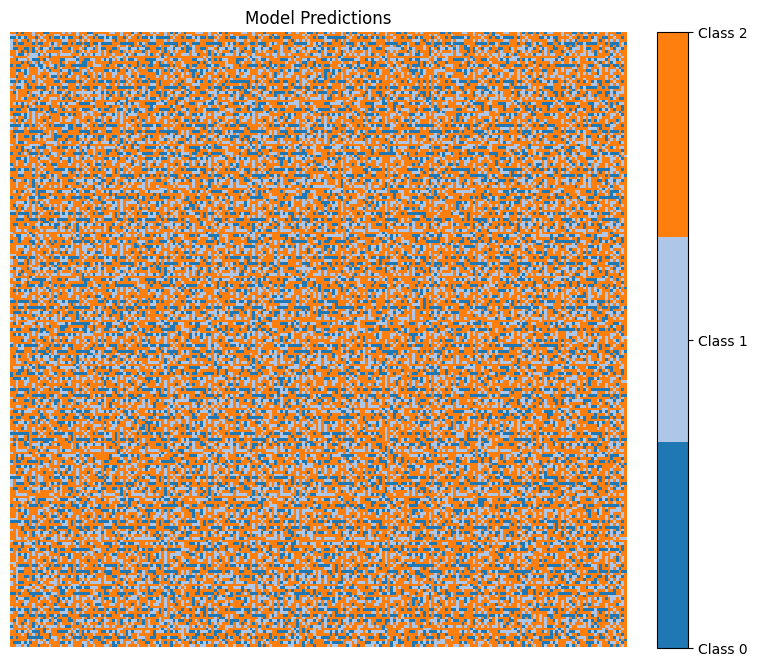

torch.Size([1, 10, 224, 224])


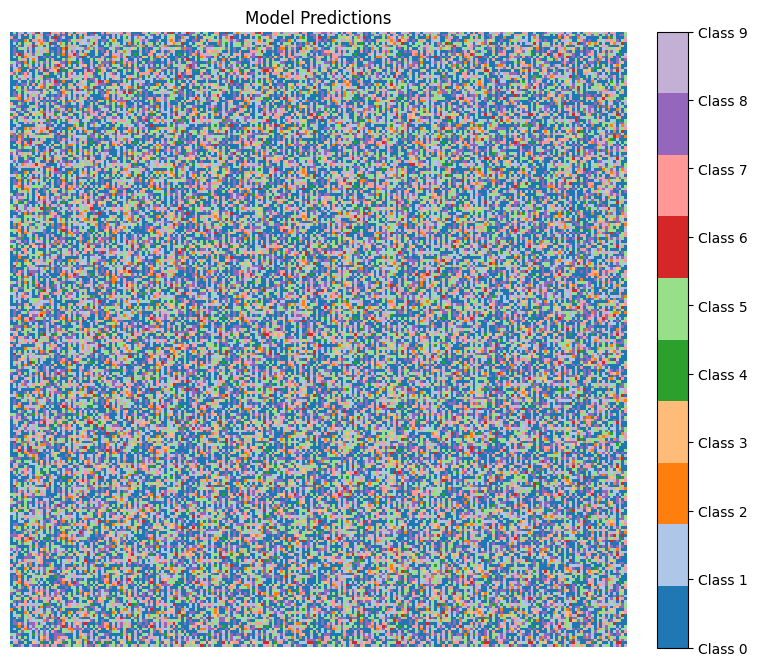

torch.Size([1, 20, 224, 224])


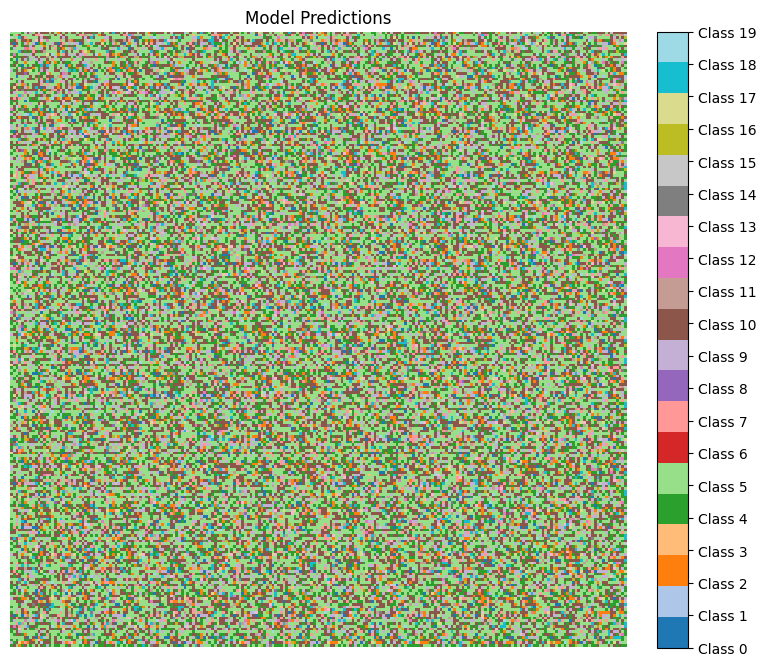

torch.Size([1, 20, 224, 224])


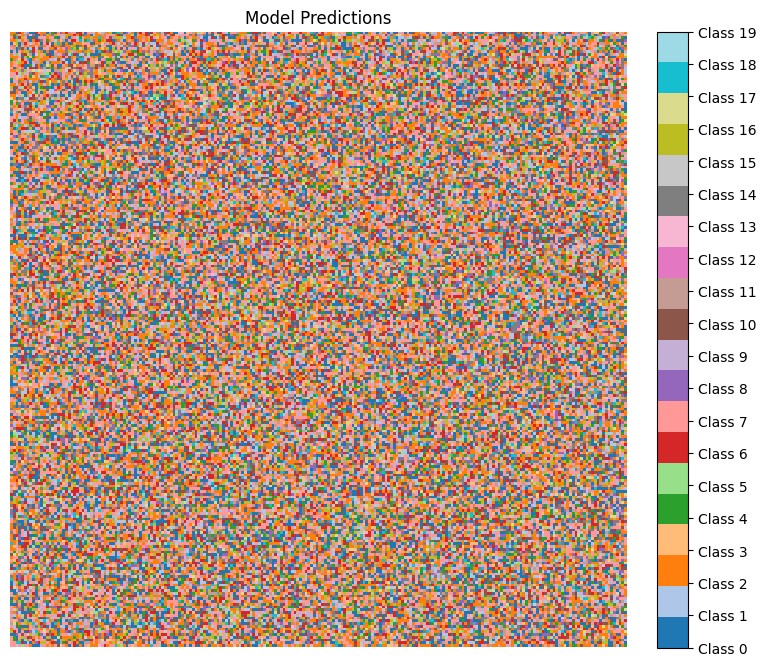

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib import colormaps

# Assuming 'outputs' is a list of your model's output tensors
for output in outputs:
    print(output.shape)  # Print the shape of the output tensor
    predictions = output.argmax(dim=1)  # Get the class predictions

    # Convert predictions to numpy for plotting
    predictions_np = predictions[0].detach().numpy()

    # Generate a color map with a distinct color for each class
    num_classes = predictions.max().item() + 1  # +1 because class count starts at 0
    cmap = ListedColormap(colormaps.get_cmap('tab20').colors[:num_classes])

    # Create the plot
    plt.figure(figsize=(10, 8))  # You can adjust the size as needed
    im = plt.imshow(predictions_np, cmap=cmap, interpolation='nearest')

    # Create colorbar with class labels
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_ticks(np.arange(num_classes))
    cbar.set_ticklabels([f'Class {i}' for i in range(num_classes)])

    # Set other plot parameters
    plt.title('Model Predictions')
    plt.axis('off') 
    plt.show()


Plotting the predictions for the given random tensor, we can see that the model is creating predictions based on the given number of classes in each tier, as expected.

## training demo

In [43]:
import torch
import torch.optim as optim

model = HierarchicalClassifier(num_classes_tier1=3, num_classes_tier2=10, num_classes_tier3=20)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    batch_size = 1  # Adjust as necessary
    height, width = 224, 224

    # Generate random input and targets
    input_tensor = torch.randn(1, 6, 3, 224, 224)  # 1 batch, 6 bands, 3 frames, 224x224
    target_tier1 = torch.randint(0, 3, (batch_size, height, width))
    target_tier2 = torch.randint(0, 10, (batch_size, height, width))
    target_tier3 = torch.randint(0, 20, (batch_size, height, width))
    target_tier3_refined = torch.randint(0, 20, (batch_size, height, width))
    targets = (target_tier1, target_tier2, target_tier3, target_tier3_refined)

    # Forward pass
    outputs = model(input_tensor)

    # Compute loss
    loss = model.calculate_loss(outputs, targets)
    total_loss += loss.item()

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print statistics
    print(f'Epoch {epoch+1}, Loss: {total_loss}')

print("Training complete.")

load from ./prithvi/models/Prithvi_100M.pt
load checkpoint from local path: ./prithvi/models/Prithvi_100M.pt
The model and loaded state dict do not match exactly

unexpected key in source state_dict: mask_token, decoder_pos_embed, decoder_embed.weight, decoder_embed.bias, decoder_blocks.0.norm1.weight, decoder_blocks.0.norm1.bias, decoder_blocks.0.attn.qkv.weight, decoder_blocks.0.attn.qkv.bias, decoder_blocks.0.attn.proj.weight, decoder_blocks.0.attn.proj.bias, decoder_blocks.0.norm2.weight, decoder_blocks.0.norm2.bias, decoder_blocks.0.mlp.fc1.weight, decoder_blocks.0.mlp.fc1.bias, decoder_blocks.0.mlp.fc2.weight, decoder_blocks.0.mlp.fc2.bias, decoder_blocks.1.norm1.weight, decoder_blocks.1.norm1.bias, decoder_blocks.1.attn.qkv.weight, decoder_blocks.1.attn.qkv.bias, decoder_blocks.1.attn.proj.weight, decoder_blocks.1.attn.proj.bias, decoder_blocks.1.norm2.weight, decoder_blocks.1.norm2.bias, decoder_blocks.1.mlp.fc1.weight, decoder_blocks.1.mlp.fc1.bias, decoder_blocks.1.mlp.fc2.we

/opt/homebrew/Caskroom/miniforge/base/envs/hls-foundation-os/lib/python3.9/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


TemporalViTEncoder IN: torch.Size([1, 6, 3, 224, 224])
TemporalViTEncoder EMBED: torch.Size([1, 588, 768])
TemporalViTEncoder OUT: torch.Size([1, 589, 768])
Features shape after base model: torch.Size([1, 589, 768])(tuple)
ConvTransformerTokensToEmbeddingNeck IN: torch.Size([1, 589, 768])
ConvTransformerTokensToEmbeddingNeck RSHP: torch.Size([1, 2304, 224, 224])
Features shape after neck: torch.Size([1, 2304, 224, 224])(tuple)
HierarchicalFCNHead forward INP:  torch.Size([1, 2304, 224, 224])
FCNHead forward INP:  torch.Size([1, 2304, 224, 224])
FCNHead forward _transform_inputs:  torch.Size([1, 2304, 224, 224])
Features shape after tier 1 head: torch.Size([1, 256, 224, 224])(tuple)
Output shape after tier 1 head: torch.Size([1, 3, 224, 224])
HierarchicalFCNHead forward INP:  torch.Size([1, 256, 224, 224])
FCNHead forward INP:  torch.Size([1, 256, 224, 224])
FCNHead forward _transform_inputs:  torch.Size([1, 256, 224, 224])
Features shape after tier 2 head: torch.Size([1, 256, 224, 224]

## check number of parameters

In [44]:
def count_parameters(model_part):
    total_params = sum(p.numel() for p in model_part.parameters())
    trainable_params = sum(p.numel() for p in model_part.parameters() if p.requires_grad)
    return total_params, trainable_params

In [57]:
model_parts = [
    {
        'model_part': model,
        'model_name': 'base model'
    },
    {
        'model_part': model.prithvi,
        'model_name': 'prithvi'
    },
    {
        'model_part': model.neck,
        'model_name': 'neck'
    },
    {
        'model_part': model.head_tier1,
        'model_name': 'head_tier1'
    },
    {
        'model_part': model.head_tier2,
        'model_name': 'head_tier2'
    },
    {
        'model_part': model.head_tier3,
        'model_name': 'head_tier3'
    },
    {
        'model_part': model.refinement_head_tier3,
        'model_name': 'refinement_head_tier3'
    }
]

for part in model_parts:
    total_params, trainable_params = count_parameters(part['model_part'])
    print(f"Model Part {part['model_name']} | Total parameters: {total_params:,}, Trainable parameters: {trainable_params:,}")

Model Part base model | Total parameters: 178,443,573, Trainable parameters: 177,991,221
Model Part prithvi | Total parameters: 86,689,536, Trainable parameters: 86,237,184
Model Part neck | Total parameters: 84,953,088, Trainable parameters: 84,953,088
Model Part head_tier1 | Total parameters: 5,309,699, Trainable parameters: 5,309,699
Model Part head_tier2 | Total parameters: 592,906, Trainable parameters: 592,906
Model Part head_tier3 | Total parameters: 595,476, Trainable parameters: 595,476
Model Part refinement_head_tier3 | Total parameters: 302,868, Trainable parameters: 302,868
